# 100 MILE TRAIL RACE FINISH TIME PREDICTOR
### Stand-Alone Dashboard and Fully Functional, Interactive User Interface
C964 Computer Science Capstone  
Western Governors University  
Russell Taylor  
December 6, 2020

# 
# Import Tools
#### Import Pandas, NumPy, and Matplotlib

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#### Set Random Seed

In [2]:
np.random.seed(45)

# 
# Import Data

In [3]:
import glob
import os
path = r'race_results'
all_files = glob.glob(os.path.join(path, "*.csv"))

race_results = pd.concat((pd.read_csv(f) for f in all_files), ignore_index = True)
race_results

,Race,Year,Cutoff,Place,First,Last,City,Location,Age,Gender,GP,Time,Rank
0,Javelina,2020,30,1,Tim,Tollefson,Mammoth Lakes,CA,35,M,1,13:28:04,96.84
1,Javelina,2020,30,2,Nick,Coury,Scottsdale,AZ,33,M,2,14:09:48,84.03
2,Javelina,2020,30,3,Nicole,Bitter,Phoenix,AZ,38,F,1,15:17:47,94.22
3,Javelina,2020,30,4,Darce,Claus,Bonners Ferry,ID,49,F,2,15:58:45,95.29
4,Javelina,2020,30,5,Sean,Van Horn,Carbondale,CO,34,M,3,16:01:10,90.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12269,Angeles Crest,2015,33,94,Peter,Hulbert,Edina,MN,36,M,74,32:28:39,59.48
12270,Angeles Crest,2015,33,95,Tim,Steele,San Ramon,CA,53,M,75,32:33:20,66.83
12271,Angeles Crest,2015,33,96,John,Kawaharada,Los Angeles,CA,47,M,76,32:36:58,66.26
12272,Angeles Crest,2015,33,97,Ryan,Launder,Landers,CA,39,M,77,32:42:04,68.24


# 
# Clean Data
#### Convert Finish Times to Integers

In [4]:
race_results["Time"] = pd.to_timedelta(race_results["Time"]).dt.total_seconds()

#### Remove DNFs and DNSs

In [5]:
race_results = race_results[race_results["Place"] > 0]
len(race_results)

11679

#### Remove Erroneous Finish Times 

In [6]:
race_results = race_results[race_results["Time"] > 43200]
outlier = race_results[race_results["Race"] == "Cascade Crest"]
race_results.drop(outlier[outlier["Time"] > 144000].index, inplace = True)
len(race_results)

11667

#### Fill Null Fields

In [7]:
race_results.fillna("INTL", inplace = True)

# 
# Descriptive Data Method: Randomized PCA
#### Remove Extraneous Columns

In [8]:
df = race_results.drop(["First", "Last", "City", "Place", "GP"], 
                       axis = 1)
list(df.columns)

['Race', 'Year', 'Cutoff', 'Location', 'Age', 'Gender', 'Time', 'Rank']

#### Convert Categorical Features to Numerical Form

In [9]:
df["Race"] = pd.Categorical(df["Race"])
df["Race"] = df["Race"].cat.codes
df["Location"] = pd.Categorical(df["Location"])
df["Location"] = df["Location"].cat.codes
df["Gender"] = pd.Categorical(df["Gender"])
df["Gender"] = df["Gender"].cat.codes

#### Split the Data into Features and Labels

In [10]:
df_shuffled = df.sample(frac = 1)
x = df_shuffled.drop("Time", axis = 1)
y = df_shuffled["Time"]

#### Split the Data into Training and Test Sets

In [11]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

#### Normalize the Feature Set with Standard Scalar Normalization

In [12]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)

#### Run the Randomized PCA Algorithm

In [13]:
from sklearn.decomposition import PCA

pca = PCA()
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)

#### Display Explained Variance

In [14]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.20713157, 0.20398593, 0.1534491 , 0.13584216, 0.12970981,
       0.08996371, 0.07991773])

# 
# Display Data
#### Display Finish Times by Race

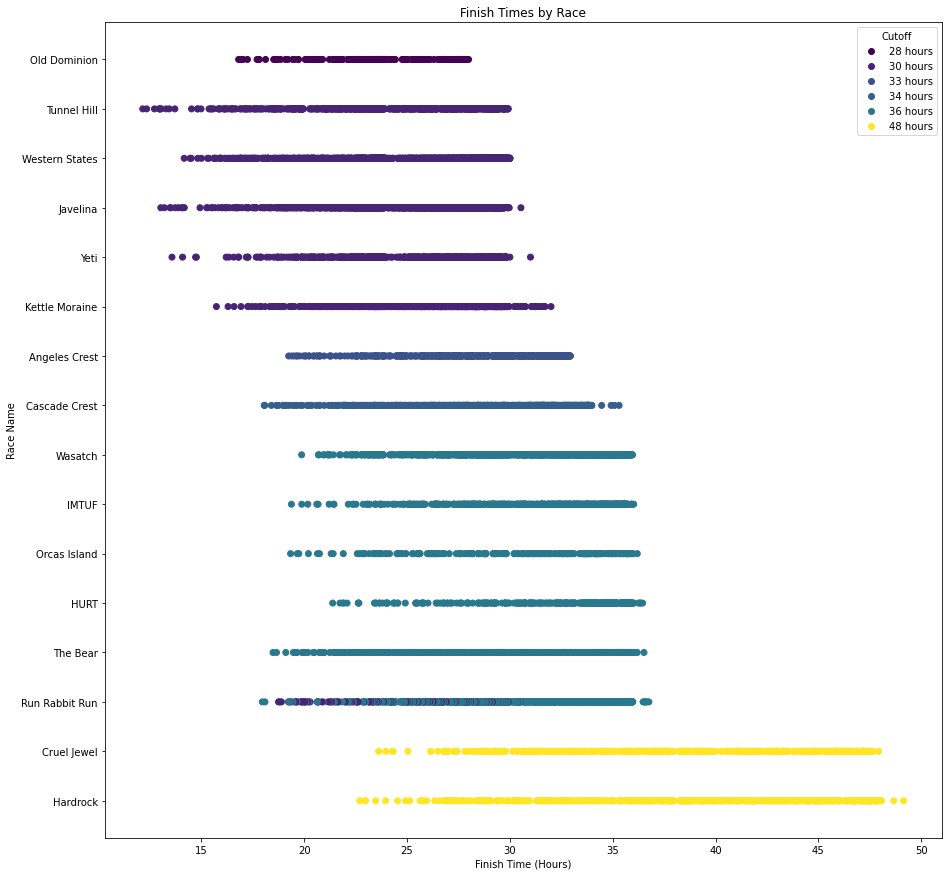

In [15]:
display = race_results.sort_values(by = "Time", ascending = False)
fig, ax = plt.subplots(figsize = (15, 15))
scatter = ax.scatter(display["Time"] / 3600, 
                     display["Race"], 
                     c = display["Cutoff"])
ax.set(title = "Finish Times by Race",
       xlabel = "Finish Time (Hours)",
       ylabel = "Race Name")
plt.legend(scatter.legend_elements()[0], 
           ("28 hours", "30 hours", "33 hours", "34 hours", "36 hours", "48 hours"), 
           title = "Cutoff")
fig.savefig("images/finish_times_by_race.png")
plt.show()

#### Display Finish Times Histogram

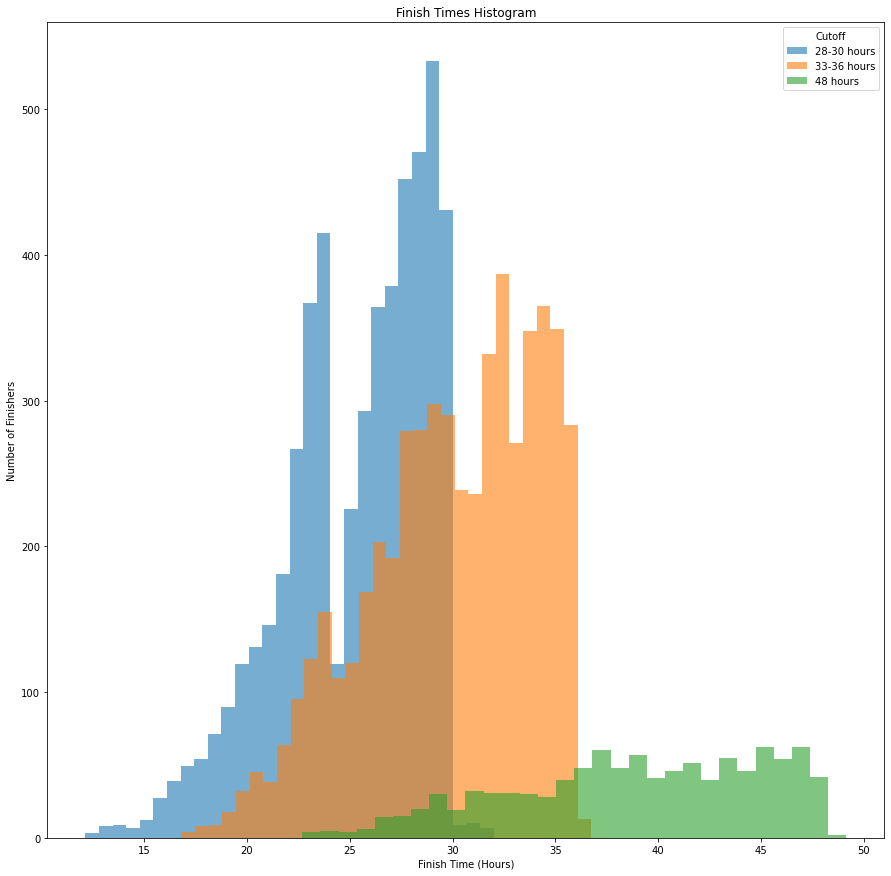

In [16]:
display = race_results
fig, ax = plt.subplots(figsize = (15, 15))

a = display[display["Cutoff"] == 30]
b = display[display["Cutoff"] == 48]
c = display.drop(a.index).drop(b.index)

ax.hist(a["Time"] / 3600, alpha = 0.6, bins = 30)
ax.hist(c["Time"] / 3600, alpha = 0.6, bins = 30)
ax.hist(b["Time"] / 3600, alpha = 0.6, bins = 30)

plt.legend(["28-30 hours", "33-36 hours", "48 hours"], title = "Cutoff")
plt.ylabel("Number of Finishers")
plt.xlabel("Finish Time (Hours)")
plt.title("Finish Times Histogram") 
fig.savefig("images/finish_times_histogram.png")
plt.show()

#### Display Finish Times by Runner Rank

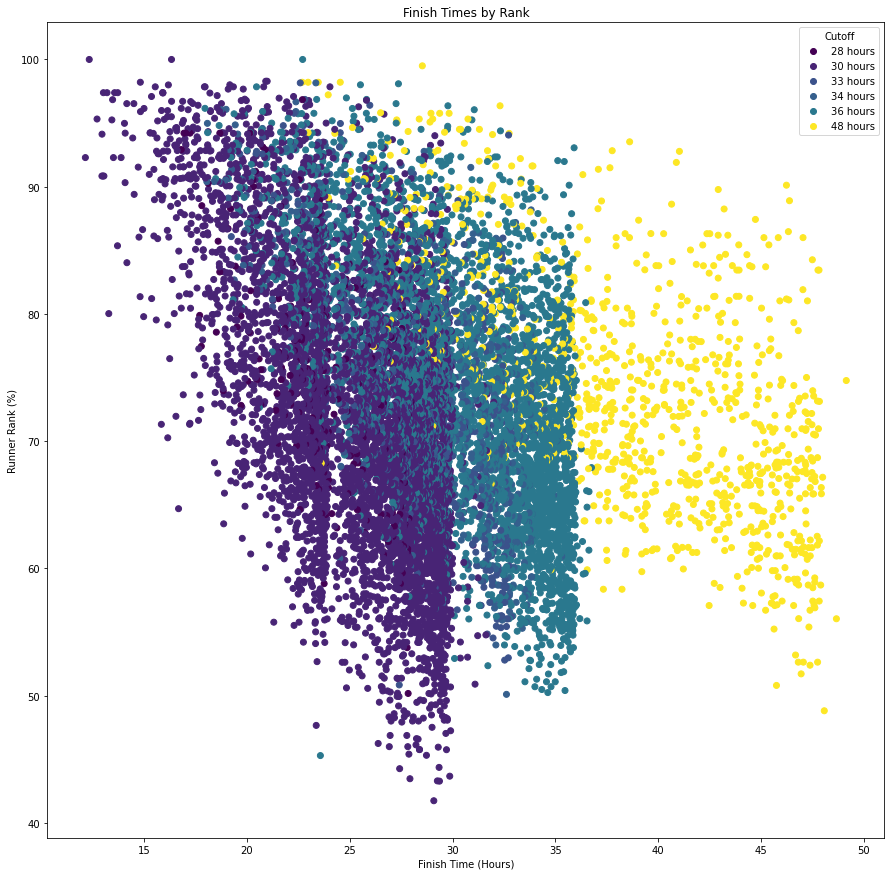

In [17]:
display = race_results.sort_values(by = "Time", ascending = False)
fig, ax = plt.subplots(figsize = (15, 15))
scatter = ax.scatter(display["Time"] / 3600, 
                     display["Rank"], 
                     c = display["Cutoff"])
ax.set(title = "Finish Times by Rank",
       xlabel = "Finish Time (Hours)",
       ylabel = "Runner Rank (%)")
plt.legend(scatter.legend_elements()[0], 
           ("28 hours", "30 hours", "33 hours", "34 hours", "36 hours", "48 hours"), 
           title = "Cutoff")
fig.savefig("images/finish_times_by_rank.png")
plt.show()

# 
# Non-Descriptive Data Method: Random Forest Regression
#### Remove Extraneous Columns

In [18]:
df = race_results.drop(["First", "Last", "Location", "City", "Place", "GP"], 
                  axis = 1)
list(df.columns)

['Race', 'Year', 'Cutoff', 'Age', 'Gender', 'Time', 'Rank']

### Convert Categorical Features to Numerical Form

In [19]:
df["Race"] = pd.Categorical(df["Race"])
df["Race"] = df["Race"].cat.codes
df["Gender"] = pd.Categorical(df["Gender"])
df["Gender"] = df["Gender"].cat.codes

#### Split the Data into Features and Labels

In [20]:
df_shuffled = df.sample(frac = 1)
x = df_shuffled.drop("Time", axis = 1)
y = df_shuffled["Time"]

#### Convert Categorical Features into Numerical Form

In [21]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer

# categorical_features = ["Gender"]
# one_hot = OneHotEncoder()
# transformer = ColumnTransformer([("one_hot", one_hot, categorical_features)], 
#                                 remainder = "passthrough")
# x = transformer.fit_transform(x)

#### Split the Data into Training and Test Sets

In [22]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)

#### Run the Random Forest Regression Algorithm

In [23]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor()
model.fit(x_train, y_train)

RandomForestRegressor()

# 
# Evaluate Results
#### Evaluate Training Set: R² Coefficient of Determination

In [24]:
model.score(x_train, y_train)

0.9697265031538366

#### Evaluate Test Set: R² Coefficient of Determination

In [25]:
model.score(x_test, y_test)

0.7953309399703318

#### Calculate the Mean Absolute Error

In [26]:
from sklearn.metrics import mean_absolute_error

y_preds = model.predict(x_test)
mae = mean_absolute_error(y_test, y_preds)

pd.to_timedelta(mae, unit = "s")

Timedelta('0 days 02:00:43.774684631')

### Display Feature Importance

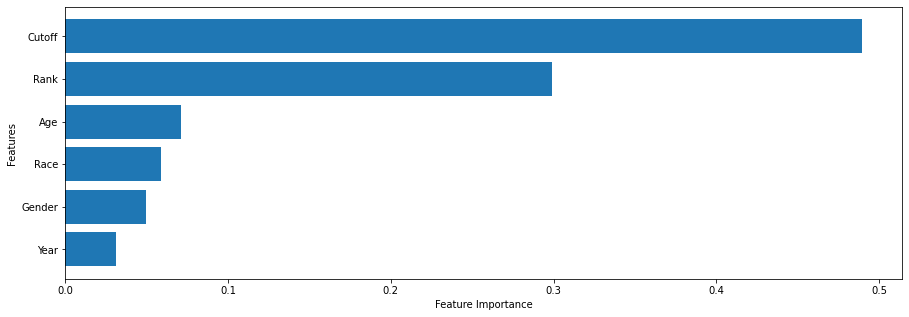

In [27]:
def plot_features(columns, importances):
    df = (pd.DataFrame({"features": columns,
                       "feature_importances": importances})
         .sort_values("feature_importances")
         .reset_index(drop = True))
    
    # Plot the DataFrame
    fig, ax = plt.subplots(figsize = (15, 5))
    ax.barh(df["features"], df["feature_importances"])
    ax.set_ylabel("Features")
    ax.set_xlabel("Feature Importance")

    fig.savefig("images/feature_importance.png")
    
plot_features(x_train.columns, model.feature_importances_)

# 
# Display Results
### Create Results DataFrame

In [28]:
df = x_test.copy()
df["Actual"] = y_test / 3600
df["Predicted"] = y_preds / 3600
df["Difference"] = df["Predicted"] - df["Actual"]
df["AbsDifference"] = abs(df["Difference"])
df

,Race,Year,Cutoff,Age,Gender,Rank,Actual,Predicted,Difference,AbsDifference
3319,12,2016,30,64,1,52.33,26.750833,28.273347,1.522514,1.522514
8977,10,2016,36,22,1,94.29,21.636667,21.885636,0.248969,0.248969
7498,13,2018,36,48,0,81.54,32.303056,33.342919,1.039864,1.039864
899,6,2018,30,33,0,74.39,28.665556,26.206964,-2.458592,2.458592
10053,1,2018,34,62,1,67.85,31.195556,30.069789,-1.125767,1.125767
...,...,...,...,...,...,...,...,...,...,...
9684,5,2017,36,37,1,70.38,29.196389,32.929372,3.732983,3.732983
8054,13,2015,36,52,1,64.62,33.803056,33.890519,0.087464,0.087464
2453,9,2018,36,30,0,80.66,29.298889,33.197044,3.898156,3.898156
2230,7,2014,30,37,1,72.78,23.195000,24.969694,1.774694,1.774694


### Display Actual Finish Time / Predicted Finish Time

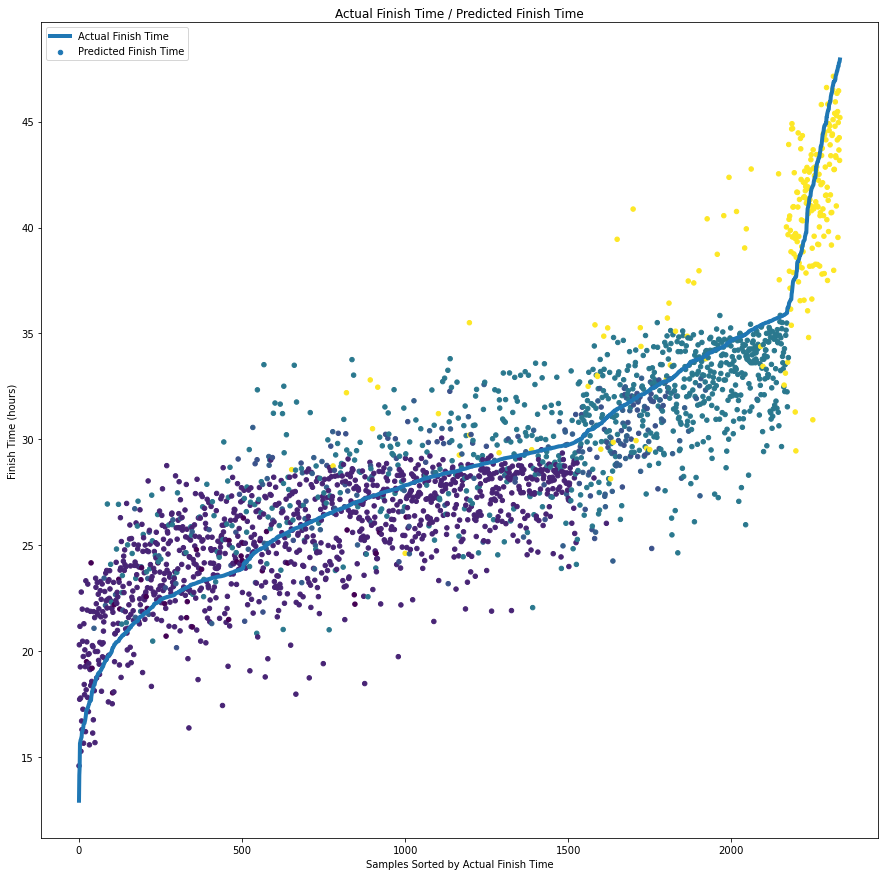

In [29]:
display = df.sort_values(by = ["Actual"])
display.reset_index(drop = True, inplace = True)
fig, ax = plt.subplots(figsize = (15, 15))
ax.plot(display.index, 
        display["Actual"], 
        linewidth = 4,
        label = "Actual Finish Time")

ax.scatter(display.index, 
           display["Predicted"], 
           s = 20,
           c = display["Cutoff"],
           label = "Predicted Finish Time")

ax.set(title = "Actual Finish Time / Predicted Finish Time",
       xlabel = "Samples Sorted by Actual Finish Time",
       ylabel = "Finish Time (hours)")
plt.legend()
fig.savefig("images/actual_predicted_finish_time.png")
plt.show()

### Display Mean Absolute Error

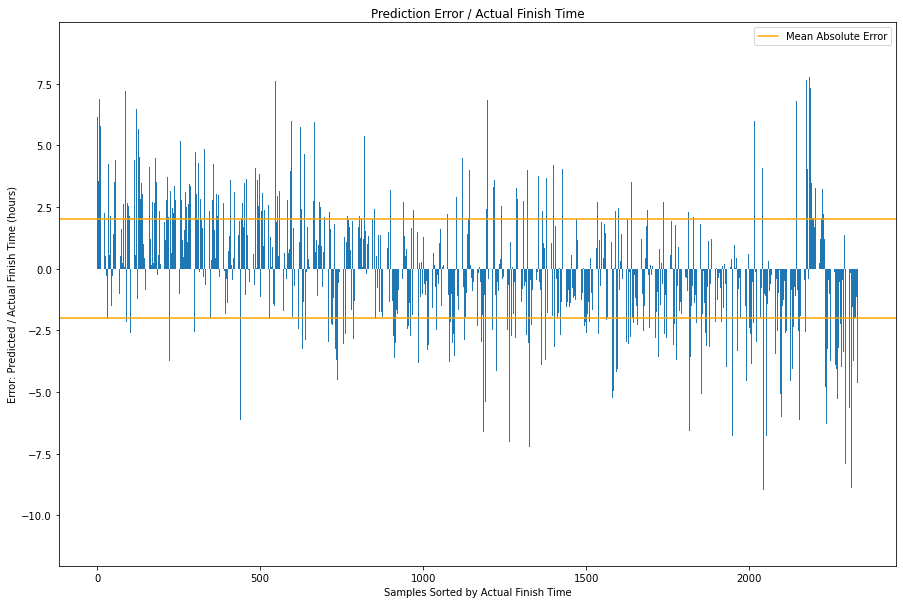

In [30]:
display = df.sort_values(by = ["Actual"])
display.reset_index(drop = True, inplace = True)
fig, ax = plt.subplots(figsize = (15, 10))

ax.bar(display.index, 
       display["Difference"])

plt.axhline(y = mae / 3600, color = "Orange", label = "Mean Absolute Error")
plt.axhline(y = -(mae / 3600), color = "Orange")

ax.set(title = "Prediction Error / Actual Finish Time",
       xlabel = "Samples Sorted by Actual Finish Time",
       ylabel = "Error: Predicted / Actual Finish Time (hours)")
plt.legend()
fig.savefig("images/mean_absolute_error.png")
plt.show()

# 
# Predict New Race Finish Time
### Input Values

In [31]:
year = 2020
cutoff = 36
age = 36
gender = 1
rank = 65.23
race = 9

### Predict Finish Time

In [32]:
df = (pd.DataFrame({"Year": [year],
                    "Cutoff": [cutoff],
                    "Age": [age],
                    "Gender": [gender],
                    "Rank": [rank],
                    "Race": [race]}))
pred = model.predict(df)
prediction = pd.to_timedelta(pred.round(0), unit = "s")
prediction[0]

Timedelta('1 days 03:33:48')

# 
# Save and Load Trained Model
### Save Trained Model

In [33]:
import pickle

In [34]:
pickle.dump(model, open("models/race_predictor_random_forest_model.pkl", "wb"))

### Load Trained Model

In [35]:
loaded_pickle_model = pickle.load(open("models/race_predictor_random_forest_model.pkl", "rb"))
loaded_pickle_model.score(x_test, y_test)

0.7953309399703318